In [1]:
PRFX = 'CV0918'

## Parameters

In [2]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
EPOCHS = 24
BS = 24

from pathlib import Path
p_out = f'../output/{PRFX}'
Path(p_out).mkdir(exist_ok=True)

## Importing libraries

In [3]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

In [4]:
ls ../input/train_images | head

0011165.jpg
002be4f.jpg
0031ae9.jpg
0035239.jpg
003994e.jpg
00498ec.jpg
006bf7c.jpg
006c5a6.jpg
008233e.jpg
008a5ff.jpg
ls: write error: Broken pipe


## Helper functions and classes

In [5]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{p_in}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Let's have a look at the data first.

In [6]:
p_in = '../input'
os.listdir(p_in)

['resnet50_coco_best_v2.1.0.h5',
 'logs',
 'test_images',
 'sample_submission.csv',
 'train_images',
 'test_images.zip',
 'train.csv.zip',
 'train.csv',
 'train_images.zip',
 'keras-retinanet']

We have folders with train and test images, file with train image ids and masks and sample submission.

In [7]:
train = pd.read_csv(f'{p_in}/train.csv')
sub = pd.read_csv(f'{p_in}/sample_submission.csv')

In [8]:
train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [9]:
n_train = len(os.listdir(f'{p_in}/train_images'))
n_test = len(os.listdir(f'{p_in}/test_images'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [10]:
train['Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     5546
Gravel    5546
Flower    5546
Fish      5546
Name: Image_Label, dtype: int64

So we have ~5.5k images in train dataset and they can have up to 4 masks: Fish, Flower, Gravel and Sugar.

In [11]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

In [12]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

But there are a lot of empty masks. In fact only 266 images have all four masks. It is important to remember this.

In [13]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

Let's have a look at the images and the masks.

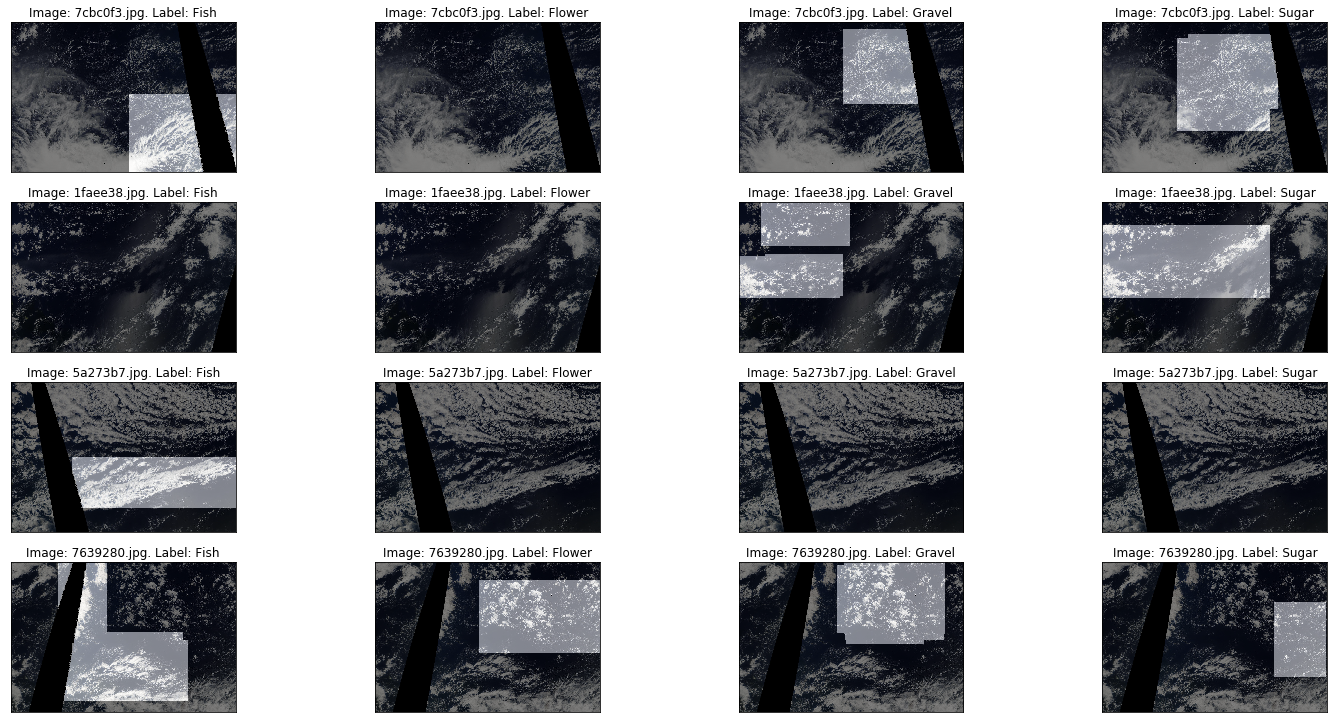

In [14]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{p_in}/train_images/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        try: # label might not be there!
            mask = rle_decode(mask_rle)
        except:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

We can see that masks can overlap. Also we can see that clouds are really similar to fish, flower and so on. Another important point: masks are often quite big and can have seemingly empty areas.

## Preparing data for modelling

At first, let's create a list of unique image ids and the count of masks for images. This will allow us to make a stratified split based on this count.

In [15]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

## Exploring augmentations with albumentations

One of important things while working with images is choosing good augmentations. There are a lot of them, let's have a look at augmentations from albumentations!

In [16]:
image_name = '8242ba0.jpg'
image = get_img(image_name)
mask = make_mask(train, image_name)

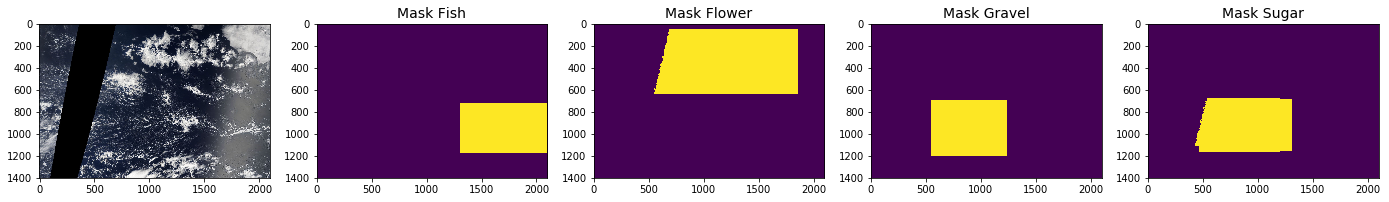

In [17]:
visualize(image, mask)

This is how original image and its masks look like. Let's try adding some augmentations

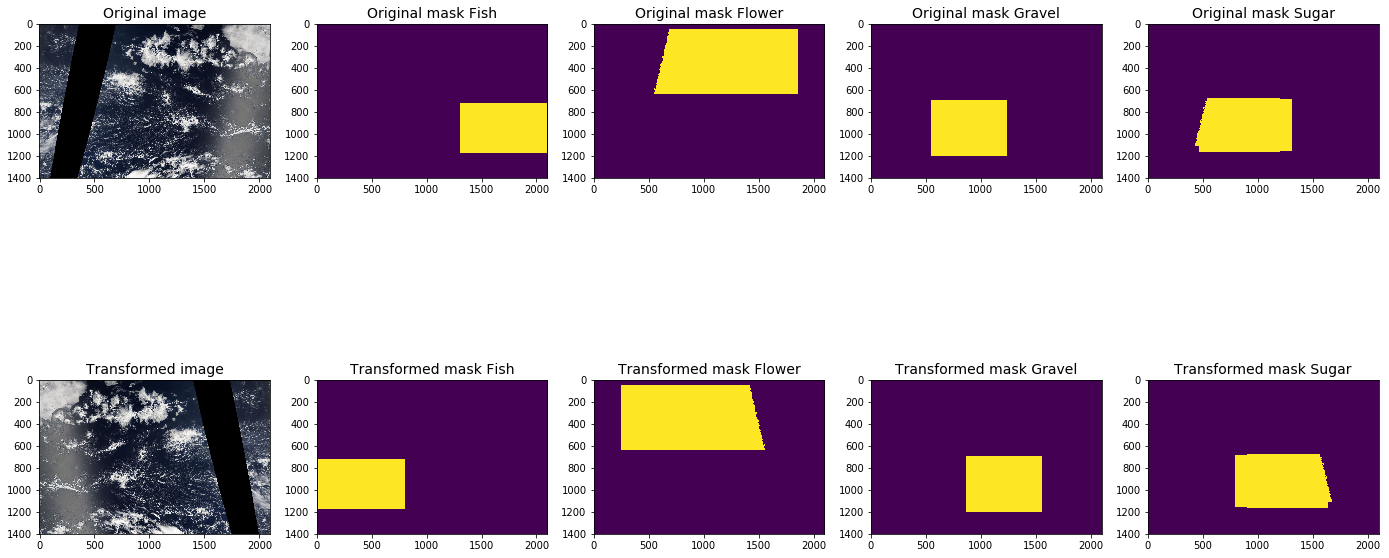

In [18]:
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

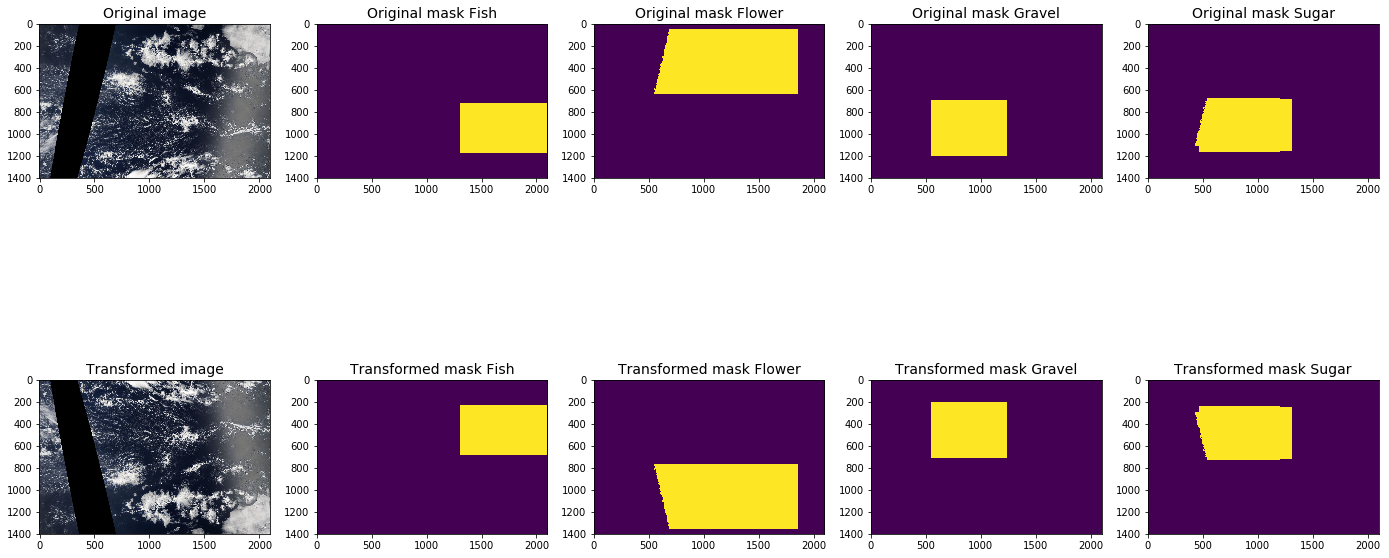

In [19]:
plot_with_augmentation(image, mask, albu.VerticalFlip(p=1))

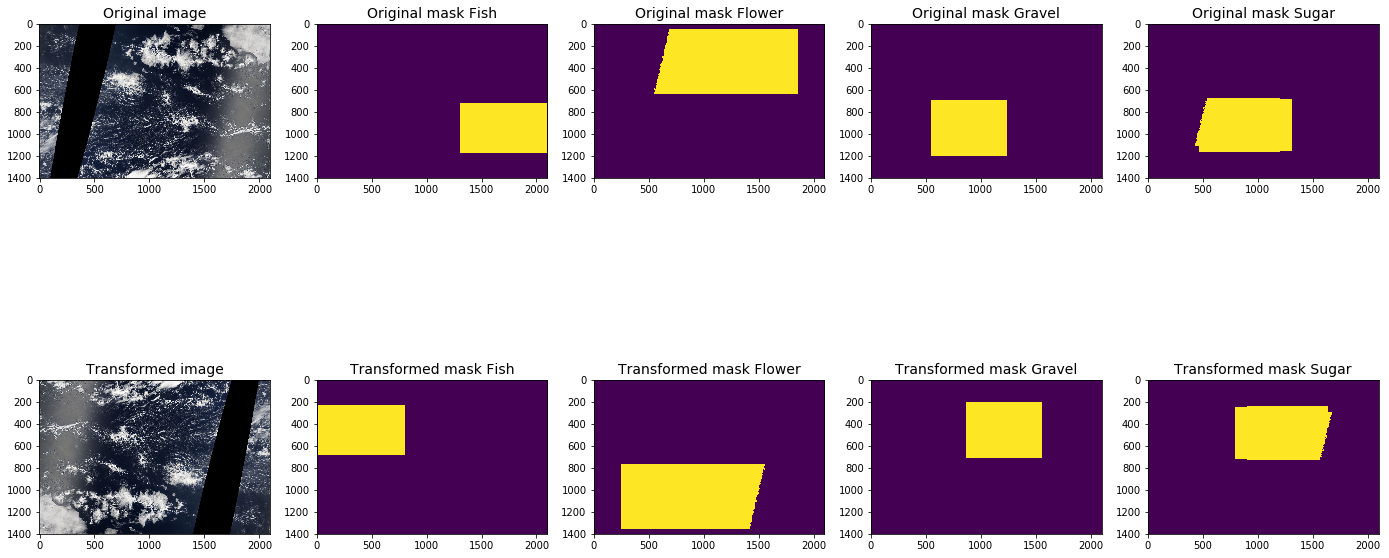

In [20]:
plot_with_augmentation(image, mask, albu.RandomRotate90(p=1))

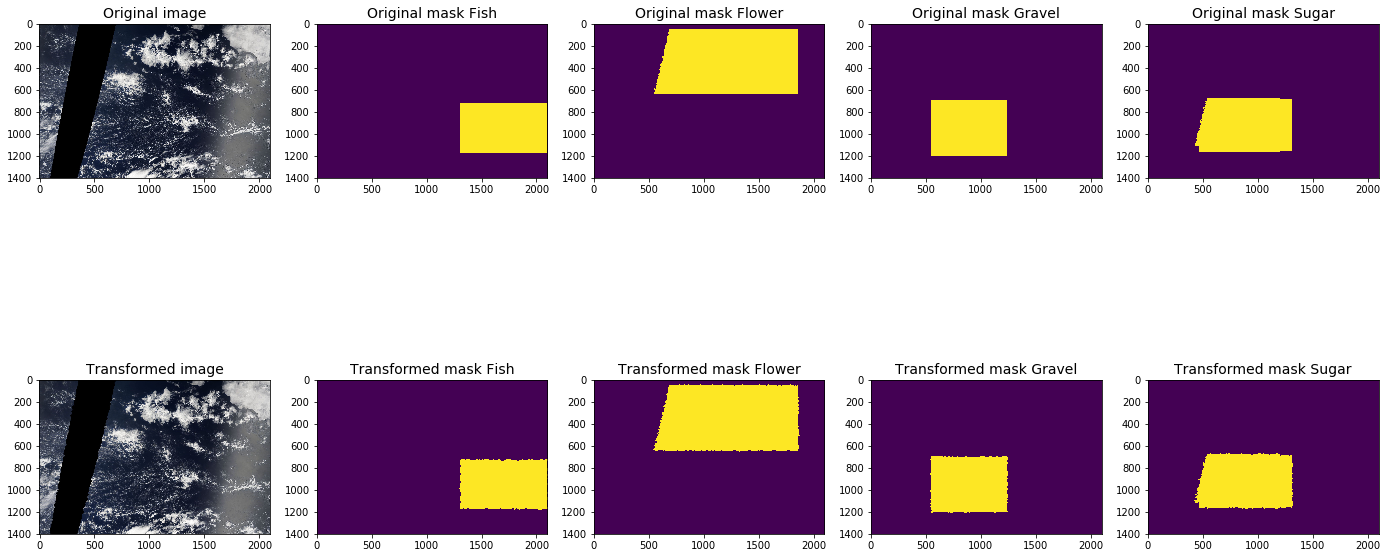

In [21]:
plot_with_augmentation(image, mask, albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03))

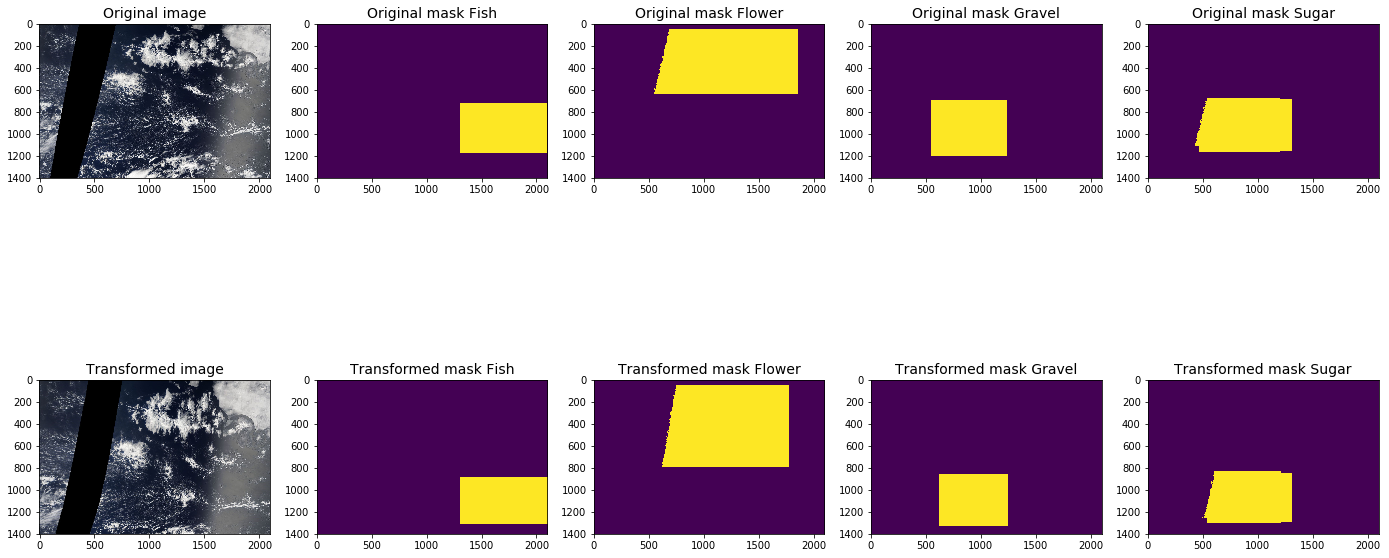

In [22]:
plot_with_augmentation(image, mask, albu.GridDistortion(p=1))

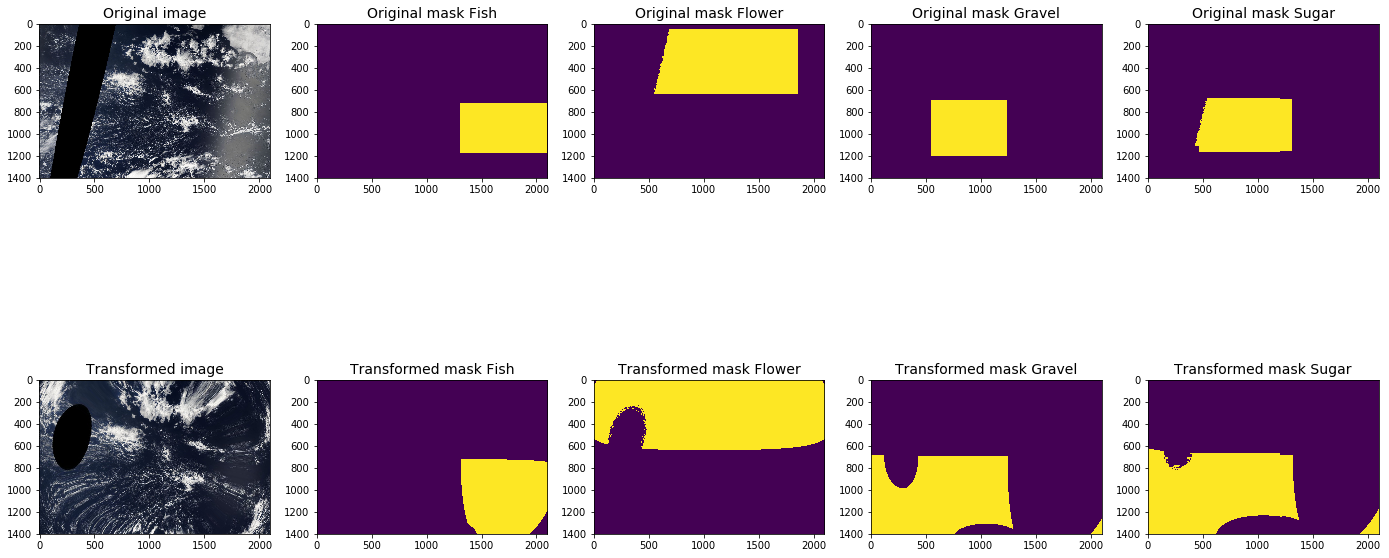

In [23]:
plot_with_augmentation(image, mask, albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5))

## Setting up data for training in Catalyst

In [24]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{p_in}/train_images"
        else:
            self.data_folder = f"{p_in}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

Now we define model and training parameters

In [25]:
# DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [26]:
num_workers = 0
bs = BS
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [27]:
num_epochs = EPOCHS
logdir = f"{p_out}/logs"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

## Model training

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/24 * Epoch (train): 100% 208/208 [15:16<00:00,  4.24s/it, _timers/_fps=6.763, dice=0.358, loss=0.997]
0/24 * Epoch (valid): 100% 24/24 [00:54<00:00,  1.75s/it, _timers/_fps=83.752, dice=0.533, loss=0.848]
[2019-09-19 03:21:42,391] 
0/24 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=6.1513 | _timers/batch_time=3.9163 | _timers/data_time=3.8996 | _timers/model_time=0.0166 | dice=0.3431 | loss=1.0458
0/24 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=13.8365 | _timers/batch_time=2.1539 | _timers/data_time=2.1425 | _timers/model_time=0.0114 | dice=0.4255 | loss=1.0187
1/24 * Epoch (train): 100% 208/208 [15:23<00:00,  4.20s/it, _timers/_fps=7.151, dice=0.449, loss=0.901]
1/24 * Epoch (valid): 100% 24/24 [00:55<00:00,  1.78s/it, _timers/_fps=79.519, dice=0.562, loss=0.747]
[2019-09-19 03:38:06,325] 
1/24 * Epoch 1 (train): _base/lr=0.0100 | _base/momentum=0.9000 | _timers/_fps=6.1008 | _timers/batch_time=3.9497 | _timers/data_time=3.9

13/24 * Epoch (train): 100% 208/208 [15:54<00:00,  4.54s/it, _timers/_fps=6.012, dice=0.527, loss=0.763]
13/24 * Epoch (valid): 100% 24/24 [00:50<00:00,  1.61s/it, _timers/_fps=81.113, dice=0.657, loss=0.559]
[2019-09-19 06:56:48,024] 
13/24 * Epoch 13 (train): _base/lr=0.0002 | _base/momentum=0.9000 | _timers/_fps=5.8843 | _timers/batch_time=4.0955 | _timers/data_time=4.0784 | _timers/model_time=0.0170 | dice=0.5211 | loss=0.7729
13/24 * Epoch 13 (valid): _base/lr=0.0002 | _base/momentum=0.9000 | _timers/_fps=14.5522 | _timers/batch_time=1.9931 | _timers/data_time=1.9815 | _timers/model_time=0.0115 | dice=0.5387 | loss=0.7572
14/24 * Epoch (train): 100% 208/208 [15:34<00:00,  4.54s/it, _timers/_fps=6.184, dice=0.498, loss=0.791]
14/24 * Epoch (valid): 100% 24/24 [00:54<00:00,  1.73s/it, _timers/_fps=84.175, dice=0.657, loss=0.568]
[2019-09-19 07:13:19,850] 
14/24 * Epoch 14 (train): _base/lr=0.0002 | _base/momentum=0.9000 | _timers/_fps=6.0158 | _timers/batch_time=4.0021 | _timers/dat

In [30]:
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "dice", 'lr', '_base/lr']
)

EventReadingError: Unexpected end of events file

## Exploring predictions
Let's make predictions on validation dataset.

At first we need to optimize thresholds 

In [31]:
encoded_pixels = []
loaders = {"infer": valid_loader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)
valid_masks = []
probabilities = np.zeros((2220, 350, 525))
for i, (batch, output) in enumerate(tqdm.tqdm(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"]))):
    image, mask = batch
    for m in mask:
        if m.shape != (350, 525):
            m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        valid_masks.append(m)

    for j, probability in enumerate(output):
        if probability.shape != (350, 525):
            probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        probabilities[i * 4 + j, :, :] = probability

=> loading checkpoint ../output/CV0918/logs/checkpoints/best.pth
loaded checkpoint ../output/CV0918/logs/checkpoints/best.pth (epoch 18)


2it [00:00, 12.54it/s]

Top best models:



555it [00:49, 11.21it/s]


## Find optimal values

First of all, my thanks to @samusram for finding a mistake in my validation
https://www.kaggle.com/c/understanding_cloud_organization/discussion/107711#622412

And now I find optimal values separately for each class.

In [32]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000]:
            masks = []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(sigmoid(probability), t, ms)
                masks.append(predict)

            d = []
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))

            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])


    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
74       0.70  10000  0.586015
79       0.75  10000  0.582601
84       0.80  10000  0.581741
78       0.75   5000  0.579138
83       0.80   5000  0.578366
1
    threshold   size      dice
74       0.70  10000  0.738496
69       0.65  10000  0.738462
79       0.75  10000  0.736657
64       0.60  10000  0.736622
78       0.75   5000  0.732118
2
    threshold   size      dice
79       0.75  10000  0.605210
84       0.80  10000  0.602145
74       0.70  10000  0.600921
64       0.60  10000  0.599281
83       0.80   5000  0.597780
3
    threshold   size      dice
64       0.60  10000  0.598955
44       0.40  10000  0.595828
48       0.45   5000  0.595232
49       0.45  10000  0.594268
43       0.40   5000  0.593883


In [33]:
print(class_params)

{0: (0.7, 10000), 1: (0.7, 10000), 2: (0.75, 10000), 3: (0.6, 10000)}


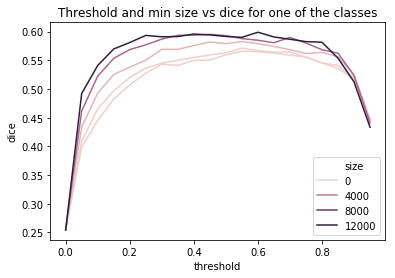

In [34]:
sns.lineplot(x='threshold', y='dice', hue='size', data=attempts_df);
plt.title('Threshold and min size vs dice for one of the classes');

Now let's have a look at our masks.

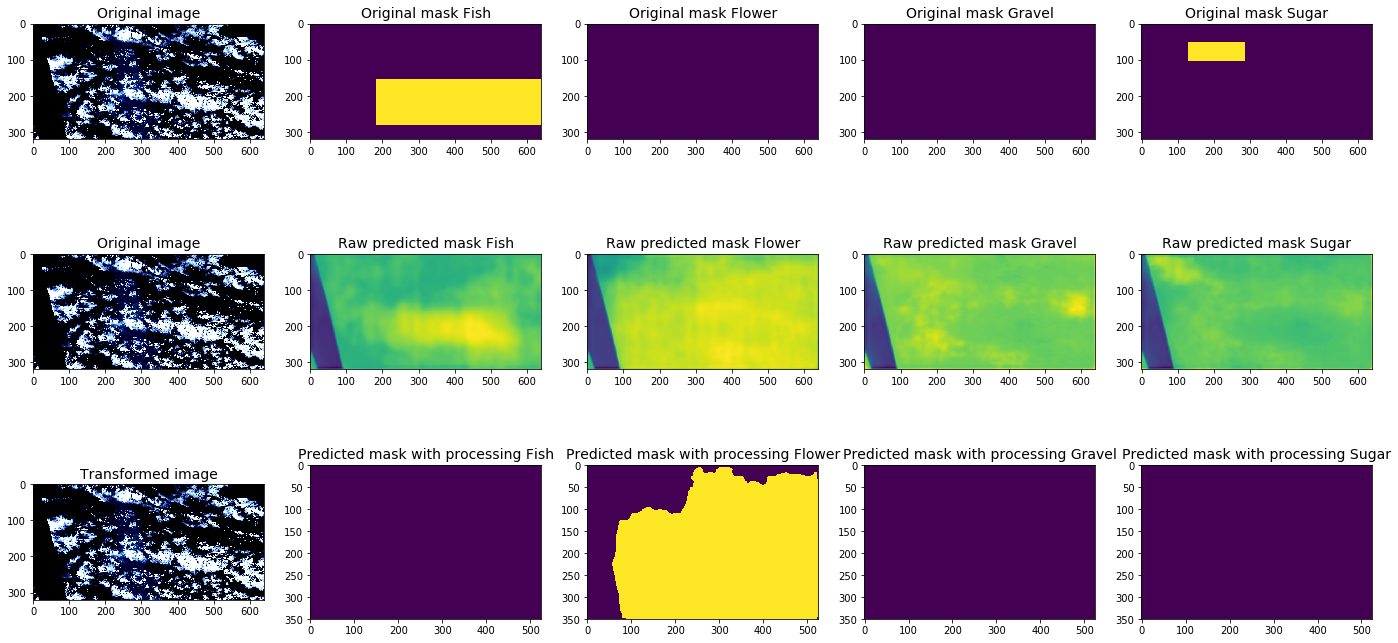

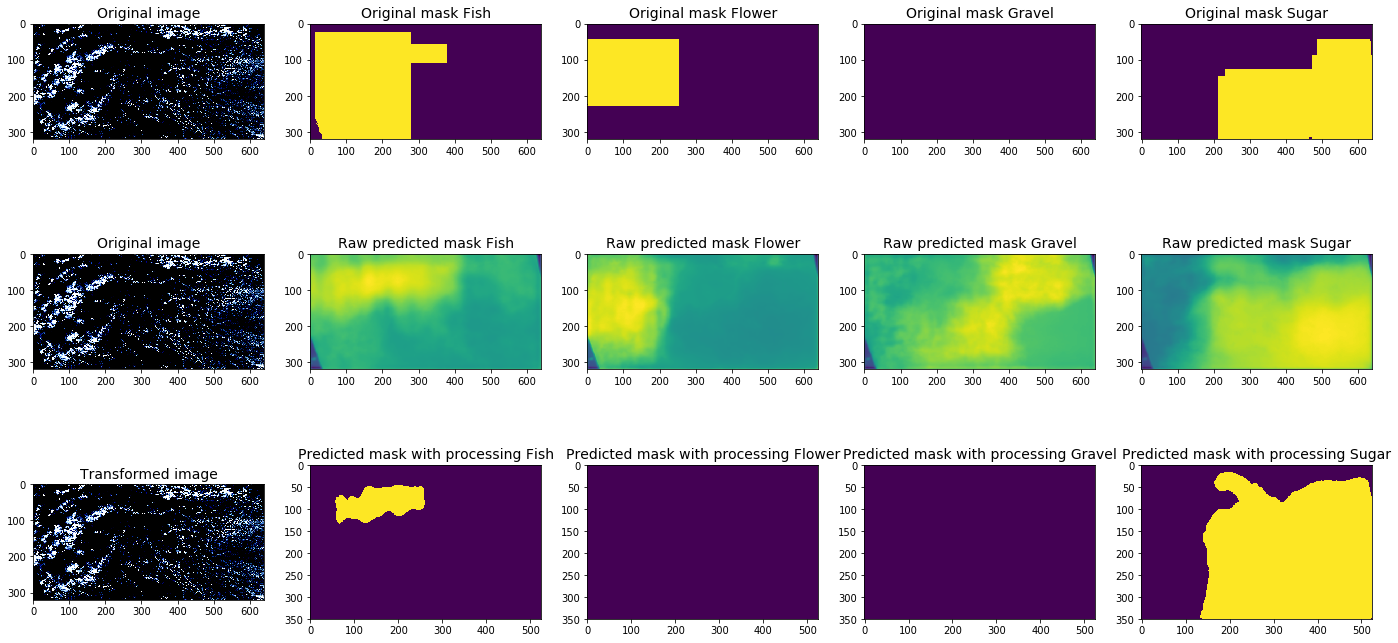

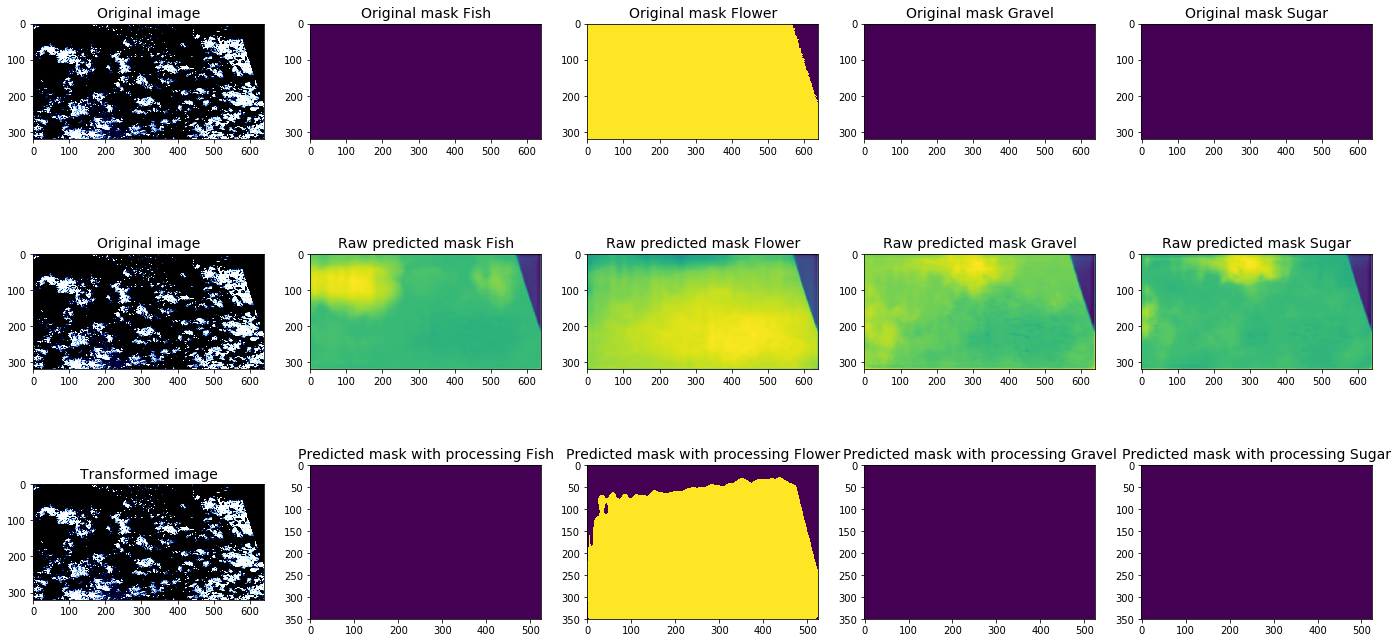

In [35]:
for i, (input, output) in enumerate(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"])):
    image, mask = input
        
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = cv2.resize(output.transpose(1, 2, 0)[:, :, j], dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        pr_mask[:, :, j], _ = post_process(sigmoid(probability), class_params[j][0], class_params[j][1])
    #pr_mask = (sigmoid(output) > best_threshold).astype('uint8').transpose(1, 2, 0)
    
        
    visualize_with_raw(image=image_vis, mask=pr_mask, original_image=image_vis, original_mask=mask, raw_image=image_vis, raw_mask=output.transpose(1, 2, 0))
    
    if i >= 2:
        break

## Predicting

In [36]:
import gc
torch.cuda.empty_cache()
gc.collect()

92316

In [37]:
test_dataset = CloudDataset(df=sub, datatype='test', img_ids=test_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

loaders = {"test": test_loader}

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:1741: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [38]:
encoded_pixels = []
image_id = 0
for i, test_batch in enumerate(tqdm.tqdm(loaders['test'])):
    runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    for i, batch in enumerate(runner_out):
        for probability in batch:
            
            probability = probability.cpu().detach().numpy()
            if probability.shape != (350, 525):
                probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(sigmoid(probability), class_params[image_id % 4][0], class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
            image_id += 1

100%|██████████| 463/463 [06:36<00:00,  1.47it/s]


In [46]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv(f'{p_out}/{PRFX}_submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

In [47]:
sub.head()

Image_Label                                      EncodedPixels   label        im_id
0    002f507.jpg_Fish                                                       Fish  002f507.jpg
1  002f507.jpg_Flower                                                     Flower  002f507.jpg
2  002f507.jpg_Gravel  372 231 604 29 706 329 1054 342 1404 343 1754 ...  Gravel  002f507.jpg
3   002f507.jpg_Sugar                                                      Sugar  002f507.jpg
4    0035ae9.jpg_Fish                                                       Fish  0035ae9.jpg

In [49]:
!head -n 4 {p_out}/{PRFX}_submission.csv

Image_Label,EncodedPixels
002f507.jpg_Fish,
002f507.jpg_Flower,
002f507.jpg_Gravel,372 231 604 29 706 329 1054 342 1404 343 1754 344 2103 345 2453 345 2803 345 3153 345 3503 346 3853 346 4203 346 4553 346 4903 346 5253 346 5603 346 5952 347 6302 347 6652 347 7002 347 7352 347 7702 347 8052 347 8402 347 8752 347 9102 347 9452 347 9802 347 10152 347 10502 347 10852 347 11202 347 11552 347 11902 347 12252 347 12602 347 12952 347 13302 347 13652 347 14002 347 14352 347 14702 347 15052 347 15402 347 15752 347 16102 347 16452 347 16802 347 17152 347 17502 347 17852 347 18202 347 18552 347 18902 347 19252 347 19602 347 19952 347 20302 347 20652 347 21002 347 21352 347 21702 347 22052 347 22402 347 22752 347 23102 347 23452 347 23802 347 24152 347 24502 347 24852 347 25202 347 25552 347 25902 347 26252 347 26602 347 26952 347 27302 347 27652 347 28002 347 28352 347 28702 347 29052 347 29402 347 29752 347 30102 347 30452 347 30802 347 31152 347 31502 347 31852 347 32202 347 32552 347 32902 347 

## references

https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools